In [31]:
import pandas as pd
import json
import myql
from yahoo_oauth import OAuth1
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

In [2]:
cols = ['Name', 'Team', 'GP', 'G', 'A', 'Pts', 'PIM', 'PPP', 'SOG', 'FW', 'Hits']
# reads 2012 data
df12 = pd.read_csv('Stats/Fantasy Hockey Stats - 2012.csv')
df12['PPP'] = df12.PPG+df12.PPA
df12 = df12[cols]
# reads 2013 data
df13 = pd.read_csv('Stats/Fantasy Hockey Stats - 2013.csv')
df13['PPP'] = df13.PPG+df13.PPA
df13 = df13[cols]
# reads 2014 data
df14 = pd.read_csv('Stats/Fantasy Hockey Stats - 2014.csv')
df14['PPP'] = df14.PPG+df14.PPA
df14 = df14[cols]
# reads 2015 data
df15 = pd.read_html(
    "http://sports.yahoo.com/nhl/stats/byposition?pos=C%2CRW%2CLW%2CD&sort=14&conference=NHL&year=season_2015",
    match = 'Name', flavor = 'bs4', header = 0)[0]
df15['PPP'] = df15.PPG+df15.PPA
df15 = df15[cols]

In [3]:
# reads goalie data
g12 = pd.read_csv('Stats/Fantasy Hockey Stats - g12.csv')
g13 = pd.read_csv('Stats/Fantasy Hockey Stats - g13.csv')
g14 = pd.read_csv('Stats/Fantasy Hockey Stats - g14.csv')
g15 = pd.read_html('http://sports.yahoo.com/nhl/stats/byposition?pos=G&sort=102&conference=NHL&year=season_2015',
    match = 'Name', flavor = 'bs4', header = 0)[0]

In [4]:
# merges data
df = df15.append(df12)
df = df.append(df13)
df = df.append(df14)
df = df.groupby('Name').sum()
gf = g15.append(g12)
gf = gf.append(g13)
gf = gf.append(g14)
gf = gf.groupby('Name').sum()

In [5]:
# creates skater average stats
df['G_avg'] = df['G']/df['GP']
df['A_avg'] = df['A']/df['GP']
df['P_avg'] = df['Pts']/df['GP']
df['PIM_avg'] = df['PIM']/df['GP']
df['PPP_avg'] = df['PPP']/df['GP']
df['SOG_avg'] = df['SOG']/df['GP']
df['FW_avg'] = df['FW']/df['GP']
df['HITS_avg'] = df['Hits']/df['GP']
avg_cols = ['GP', 'G_avg', 'A_avg', 'P_avg', 'PIM_avg', 'PPP_avg', 
            'SOG_avg', 'FW_avg', 'HITS_avg']
skaters = df[avg_cols]

In [6]:
# creates goalie average stats
gf_cols = ['GP', 'MIN', 'SV', 'SA', 'GA']
gf = gf[gf_cols]
gf['SV%'] = gf['SV']/gf['SA']
gf['GAA'] = gf['GA']/ (gf['MIN'] / 60)
gf['POS'] = 'G'
gf['SV_avg'] = gf['SV']/gf['GP']
gfGP = gf['GP']
gf = gf[['GAA', 'SV_avg', 'SV%']]
gf['GAA'] = gf['GAA'] * -1

In [7]:
# adds positions
file = pd.read_csv('Stats/Fantasy Hockey Stats - Defense.csv')
defense = df[avg_cols][df.index.isin(file['Name'])]
forwards = df[avg_cols][~df.index.isin(file['Name'])]

# limits to players active this season
defense = defense[defense.index.isin(df15['Name'])]
forwards = forwards[forwards.index.isin(df15['Name'])]
goalies = gf[gf.index.isin(g15['Name'])]

In [8]:
# strips and saves games played data
skatersGP = skaters.GP
skaters = skaters[skaters.columns[1:]]
defenseGP = defense.GP
defense = defense[defense.columns[1:]]
forwardsGP = forwards.GP
forwards = forwards[forwards.columns[1:]]

In [9]:
# normalizes data

defense_norm = (defense - defense.mean()) / defense.std()
defense_norm['Score'] = defense_norm.sum(axis=1)
defense_norm['GP'] = defenseGP

forwards_norm = (forwards - forwards.mean()) / forwards.std()
forwards_norm['Score'] = forwards_norm.sum(axis=1)
forwards_norm['GP'] = forwardsGP

goalies_norm = (goalies - goalies.mean()) / goalies.std()
goalies_norm['Score'] = goalies_norm.sum(axis=1)
goalies_norm['GP'] = gfGP

In [10]:
# ranks by position

defense = defense_norm.sort('Score', ascending=False)
rank = list(range(1,len(defense)+1))
defense['PRank'] = rank
defense['POS'] = 'D'
defense = defense[['PRank', 'Score', 'POS', 'GP','G_avg', 'A_avg', 'P_avg', 
                   'PIM_avg', 'PPP_avg', 'SOG_avg', 'FW_avg', 'HITS_avg']]

forwards = forwards_norm.sort('Score', ascending=False)
rank = list(range(1,len(forwards)+1))
forwards['PRank'] = rank
forwards['POS'] = 'F'
forwards = forwards[['PRank', 'Score', 'POS', 'GP','G_avg', 'A_avg', 'P_avg',
                     'PIM_avg', 'PPP_avg', 'SOG_avg', 'FW_avg', 'HITS_avg']]

goalies = goalies_norm.sort('Score', ascending=False)
rank = list(range(1,len(goalies)+1))
goalies['PRank'] = rank
goalies['POS'] = 'G'
goalies = goalies[['PRank', 'Score', 'POS', 'GP','GAA', 'SV_avg', 'SV%']]

In [11]:
# merges positions and adds overall rank
allskaters = defense.append(forwards)
allskaters = allskaters.append(goalies)
allskaters = allskaters.sort('Score', ascending = False)
ORank = list(range(1, len(allskaters)+1))
allskaters['ORank'] = ORank
allskaters['Team'] = 'FA'
allskaters = allskaters[['ORank', 'PRank', 'Score', 'Team', 'POS', 'GP','G_avg', 'A_avg', 
                         'P_avg', 'PIM_avg', 'PPP_avg', 'SOG_avg', 'FW_avg', 'HITS_avg',
                        'GAA', 'SV_avg', 'SV%']]

In [12]:
oauth = OAuth1(None, None, from_file='credentials.json')
yql = myql.MYQL(oauth = oauth)

[2016-03-31 11:29:14,460 DEBUG] [yahoo_oauth.yahoo_oauth.__init__] Checking 
[2016-03-31 11:29:14,465 DEBUG] [yahoo_oauth.yahoo_oauth.token_is_valid] ELAPSED TIME : 120672.08441901207
[2016-03-31 11:29:14,466 DEBUG] [yahoo_oauth.yahoo_oauth.token_is_valid] TOKEN HAS EXPIRED
[2016-03-31 11:29:14,467 DEBUG] [yahoo_oauth.yahoo_oauth.refresh_access_token] REFRESHING TOKEN


In [13]:
response = yql.raw_query("select * from fantasysports.teams.roster where league_key='352.l.63158'")
data = response.json()

[2016-03-31 11:29:15,275 DEBUG] [yahoo_oauth.yahoo_oauth.token_is_valid] ELAPSED TIME : 0.8072900772094727
[2016-03-31 11:29:15,276 DEBUG] [yahoo_oauth.yahoo_oauth.token_is_valid] TOKEN IS STILL VALID


In [14]:
with open('rosters.json', 'w') as outfile:
    json.dump(data, outfile)

In [15]:
# creates dict of team rosters
with open('rosters.json') as data_file:    
    data = json.load(data_file)
teams = []
for num in range(0,14):
    teams.append(data['query']['results']['team'][num]['name'])
count = 0
rosters = {}
for team in teams:
    rosters[team] = []
    for num in range(0, int(data['query']['results']['team'][count]
                            ['roster']['players']['count'])):
        rosters[team].append(data['query']['results']['team'][count]
                             ['roster']['players']['player'][num]['name']['full'])
    count +=1

In [16]:
# creates dataframe of each team and adds team to allskaters
Game_of_Doans = allskaters[allskaters.index.isin(rosters['Game of Doans'])]
Horsedick = allskaters[allskaters.index.isin(rosters['Horsedick.mpeg'])]
Fists_of_Fleury = allskaters[allskaters.index.isin(rosters['Fists of Fleury'])]
Munson_Munson = allskaters[allskaters.index.isin(rosters['Munson Munson'])]
The_Ants = allskaters[allskaters.index.isin(rosters['The Ants'])]
Ricks_Red_Wingels = allskaters[allskaters.index.isin(rosters["Rick's Red Wingels"])]
CamelToews = allskaters[allskaters.index.isin(rosters['CamelToews'])]
Sarahs_Super_Team = allskaters[allskaters.index.isin(rosters["Sarah's Super Team"])]
Nordic_Supermen = allskaters[allskaters.index.isin(rosters['Nordic Supermen'])]
DeKeyser = allskaters[allskaters.index.isin(rosters['DeKeyser Söze'])]
Shiroi_Kabocha = allskaters[allskaters.index.isin(rosters['Shiroi Kabocha'])]
Brooklyn_Solar_Bears = allskaters[allskaters.index.isin(rosters['Brooklyn Solar Bears'])]
STEPANWOLF = allskaters[allskaters.index.isin(rosters['STEPANWOLF'])]
Caress_of_Krieger = allskaters[allskaters.index.isin(rosters['Caress of Krieger'])]

allskaters['Team'][allskaters.index.isin(Game_of_Doans.index)] = 'Game of Doans'
allskaters['Team'][allskaters.index.isin(Horsedick.index)] = 'Horsedick.mpeg'
allskaters['Team'][allskaters.index.isin(Fists_of_Fleury.index)] = 'Fists of Fleury'
allskaters['Team'][allskaters.index.isin(Munson_Munson.index)] = 'Munson Munson'
allskaters['Team'][allskaters.index.isin(The_Ants.index)] = 'The Ants'
allskaters['Team'][allskaters.index.isin(Ricks_Red_Wingels.index)] = "Rick's Red Wingels"
allskaters['Team'][allskaters.index.isin(CamelToews.index)] = 'CamelToews'
allskaters['Team'][allskaters.index.isin(Sarahs_Super_Team.index)] = "Sarah's Super Team"
allskaters['Team'][allskaters.index.isin(Nordic_Supermen.index)] = 'Nordic Supermen'
allskaters['Team'][allskaters.index.isin(DeKeyser.index)] = 'DeKeyser Söze'
allskaters['Team'][allskaters.index.isin(Shiroi_Kabocha.index)] = 'Shiroi Kabocha'
allskaters['Team'][allskaters.index.isin(Brooklyn_Solar_Bears.index)] = 'Brooklyn Solar Bears'
allskaters['Team'][allskaters.index.isin(STEPANWOLF.index)] = 'STEPANWOLF'
allskaters['Team'][allskaters.index.isin(Caress_of_Krieger.index)] = 'Caress of Krieger'

Game_of_Doans = allskaters[allskaters.index.isin(rosters['Game of Doans'])]
Horsedick = allskaters[allskaters.index.isin(rosters['Horsedick.mpeg'])]
Fists_of_Fleury = allskaters[allskaters.index.isin(rosters['Fists of Fleury'])]
Munson_Munson = allskaters[allskaters.index.isin(rosters['Munson Munson'])]
The_Ants = allskaters[allskaters.index.isin(rosters['The Ants'])]
Ricks_Red_Wingels = allskaters[allskaters.index.isin(rosters["Rick's Red Wingels"])]
CamelToews = allskaters[allskaters.index.isin(rosters['CamelToews'])]
Sarahs_Super_Team = allskaters[allskaters.index.isin(rosters["Sarah's Super Team"])]
Nordic_Supermen = allskaters[allskaters.index.isin(rosters['Nordic Supermen'])]
DeKeyser = allskaters[allskaters.index.isin(rosters['DeKeyser Söze'])]
Shiroi_Kabocha = allskaters[allskaters.index.isin(rosters['Shiroi Kabocha'])]
Brooklyn_Solar_Bears = allskaters[allskaters.index.isin(rosters['Brooklyn Solar Bears'])]
STEPANWOLF = allskaters[allskaters.index.isin(rosters['STEPANWOLF'])]
Caress_of_Krieger = allskaters[allskaters.index.isin(rosters['Caress of Krieger'])]

FA = allskaters[allskaters.Team == 'FA']

//anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
//anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
//anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
//anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

In [17]:
def lookup(*args):
    players = list(args)
    return(allskaters[allskaters.index.isin(players)])

def value(player):
    return lookup(player).append(Game_of_Doans[Game_of_Doans['Score'] 
                                               < list(lookup(player)['Score'])])
def compare(team):
    compare = allskaters.groupby('Team').sum()
    compare = compare.drop('FA')
    compare = compare[['G_avg', 'A_avg', 'P_avg', 'PIM_avg', 'PPP_avg', 
         'SOG_avg', 'FW_avg', 'HITS_avg', 'GAA', 'SV_avg', 'SV%']]
    compare = compare[compare.index.isin([team])].append(
        compare[compare.index.isin(['Game of Doans'])])
    return(compare)

def rankings():
    df = allskaters.groupby('Team').sum().drop('FA').ix[:,'G_avg':]
    for col in df:
        df[col] = df[col].rank(ascending = False)
    df['Rank'] = df.mean(axis=1)
    df['Rank'] = df['Rank'].rank()
    return(df[['Rank', 'G_avg', 'A_avg', 'P_avg', 'PIM_avg', 'PPP_avg', 
         'SOG_avg', 'FW_avg', 'HITS_avg', 'GAA', 'SV_avg', 'SV%']].sort_values('Rank'))

In [47]:
Game_of_Doans.to_csv('team.csv')

In [19]:
allskaters.sort('P_avg', ascending = False).head()

,ORank,PRank,Score,Team,POS,GP,G_avg,A_avg,P_avg,PIM_avg,PPP_avg,SOG_avg,FW_avg,HITS_avg,GAA,SV_avg,SV%
Name,,,,,,,,,,,,,,,,,
Casey Nelson,22,14,11.412550,FA,F,3,-1.344678,6.720640,3.859573,-1.061313,5.956055,-1.644463,-0.687475,-0.385790,NaN,NaN,NaN
Erik Karlsson,4,2,16.921034,Horsedick.mpeg,D,258,3.365156,3.600106,3.741999,-0.061678,3.137665,3.542322,-0.130995,-0.273542,NaN,NaN,NaN
Kris Letang,6,4,16.392217,The Ants,D,207,2.702558,3.417583,3.399021,0.660970,3.170712,2.783932,-0.130995,0.388436,NaN,NaN,NaN
Sidney Crosby,2,1,17.618875,Brooklyn Solar Bears,F,268,2.391430,3.459754,3.349086,0.081775,3.264779,2.159147,3.503633,-0.590729,NaN,NaN,NaN
Brent Burns,1,1,31.638642,Game of Doans,D,258,4.437301,2.165337,3.002452,0.340621,2.109303,3.824511,15.328900,0.430216,NaN,NaN,NaN


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x130f3d780>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1318ca358>]], dtype=object)

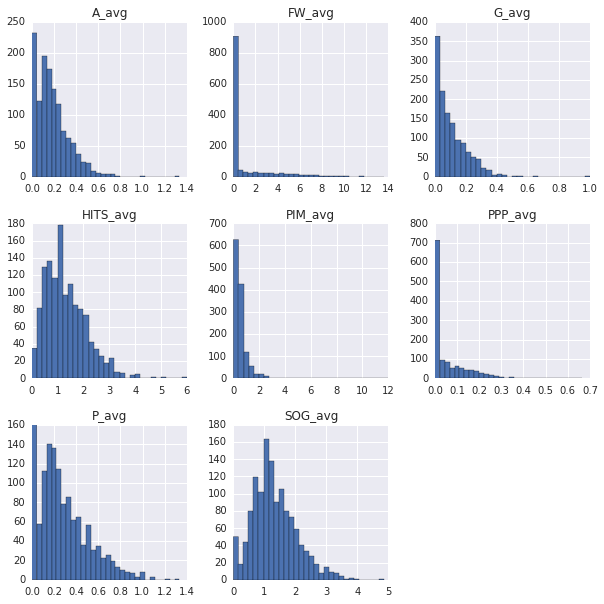

In [43]:
skaters.hist(bins = 30, figsize = (10,10))